# Modeling The Three Body Problem with Symmetries
In this project we sought to model the three body problem by incorporating different symmetries into the neural network. We use a couple of different methods for making predictions on the three body problem. First we try developing a Hamiltonian Neural Network [1] and train it to directly predict the acceleration and velocity at each time step. However, Hamiltonian ODEs rely on training using the ground truth of acceleration which greatly simplifies the problem. As in this case, the acceleration is a simple inverse square function of the inputs. Furthermore, the acceleration may be unknown when studying more complicated systems. As a result we develop several Neural ODEs [2] that model the data only using the ground truth of position and velocity. We also incorporate several symmetries into the problem using techniques from [3].

We would not recommend re-running some of these cells. The Hamiltonian Neural Networks only take about 3-4 minutes to run, but some of the Neural ODEs were trained for hours on the BYU super computer with much better GPUs. We have included several folders with simulations of the three body problem for various architectures.

## Literature Review
[1] Sam Greydanus, Misko Dzamba, & Jason Yosinski. (2019). Hamiltonian Neural Networks.

This works seeks to learn differential equations that model Hamiltonian systems. Many different systems can be fully characterized by the energy equation called the Hamiltonian. The Hamiltonian not only predicts the energy of a system but its derivatives predict both change in momentum and change in position. In this work, they train a neural network that predicts the hamiltonian of a system by backpropagating to make the partial derivatives of the network match the change in momentum and positions of the hamiltonian.

In their work they predict energies of several different systems: The ideal mass spring, ideal pendulum, and the real pendulum. They also try to model the two and three body problem but are unable to get very good results with the three body problem. We use portions of their code when generating the datasets for our three body problem.

[2] Ricky T. Q. Chen, Yulia Rubanova, Jesse Bettencourt, & David Duvenaud. (2019). Neural Ordinary Differential Equations.

This work proposes using ODE solvers as a version of residual connections for neural networks. The inspiration for this is that residual connections look a lot like forward euler integration. Their idea was to use feedforward neural network as the update equation in the ODE solver and then backpropagate through the ODE solver. However, backpropagating through an ODE solver can be very costly. So as a result, they propose an adjoint method that allows us to not have to differentiate all the way through the ODE solver and do backpropagation in $O(1)$ time.  Additionally, they model time series using a Latent Neural ODE that is able to filter out noise using a Variational Auto-Encoder.

In our work we do not use the adjoint method they propose. This is because we found it took much longer than just backpropagating through the solver initially.

[3] Soledad Villar, David W. Hogg, Kate Storey-Fisher, Weichi Yao, & Ben Blum-Smith. (2023). Scalars are universal: Equivariant machine learning, structured like classical physics.

This paper shows that non-linear group equivariant functions are universally expressed as linear combinations of the scalar, vector, and tensor inputs. They prove how different functions that are equivariant to some group action must be represented. Importantly they show how functions that are translationally, rotationally, and permutation equivariant must be represented as linear combinations of predicted scalers and input vectors. Using this framework they explore several examples of how they can learn some arbitrary function with a neural network by hardcoding in the equivariance.

This paper is very important to our problem. They prove how our functions must be represented in order to be invariant under some group action. We incorporate their methods when developing symmetries for the three body problem and see some awesome results.

[4] Behrooz Tahmasebi, & Stefanie Jegelka (2023). The Exact Sample Complexity Gain from Invariances for Kernel Regression. In Thirty-seventh Conference on Neural Information Processing Systems.

This work examines the exact sample complexity gains from encoding invariances into a model. They study this in the specific example of kernel ridge regression, but state that it heuristically looks very similar in the neural network case. They show that when you train m samples under a certain invariant finite group G, you are essentially training on $m|G|$ samples. In the infinite case they find that by increasing the size of the group you reduce the exponent on the expected emperical risk.

Applied to our problem, if we incorporate translational, rotational, and permutation equivariance we should expect that our expected risk should be proportional to $(\frac{\text{Vol(possible data)}}{6m})^{\frac{s}{s+3/2}}$ where s is the p-norm of the space of sobelev functions we are considering.



## Hamiltonian Neural Networks
In this first section we explore trying to model the three body system with Hamiltonian Neural Networks

The basic idea between a Hamiltonian Neural Network is to train a neural network to match the Hamiltonian or total energy of a system. So given the state of a system $x$, $H(x)$ produces the total energy of the system. However, we do not train to model this directly; rather, we train a neural network approximation $\hat H(x)$ where we run gradient descent on the derivatives of a neural network.

More formally the Hamiltonian of a system typically takes in two inputs: position $p$ and momentum $q$. The hamiltonian equations tell us that $\frac{\partial H}{\partial p}=\frac{\partial q}{\partial t}$ and $\frac{\partial H}{\partial q}=-\frac{\partial p}{\partial t}$. So during training time we calculate the MSE loss between $\frac{\partial \hat H}{\partial p}$ and $\frac{\partial q}{\partial t}$ in addition to $\frac{\partial \hat H}{\partial q}$ and $-\frac{\partial p}{\partial t}$ so that our approximation $\hat H$ in truth represents the hamiltonian. At test time we then set $\frac{\partial q}{\partial t}=\frac{\partial \hat H}{\partial p}$ and $\frac{\partial p}{\partial t}=-\frac{\partial\hat H}{\partial q}$ when running things through the ODE solver.

We have examples comparing the Hamiltonian method to just naively computing predictions and typically the Hamiltonian works much better.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
from scipy.integrate import odeint
from data import get_orbit,random_config,sample_orbits,sample_orbits_grouped
from scipy.integrate import odeint
from torchdiffeq import odeint as todeint
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os.path


### Dataset generation and initialization
- The following code should take about ~10 minutes to run assuming you do not have the data already downloaded

In [2]:
class PlanetaryData(Dataset):
    def __init__(self, x, dxdt):
        self.x = x
        self.dxdt = dxdt
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.dxdt[idx]
fname = "smaller_dataset"
if not os.path.isfile(f"{fname}_x_coords.pt"):

    data,_ = sample_orbits(time_steps = 80,trials = 5000,t_span=[0,20])
    x = torch.tensor( data['coords'], requires_grad=True, dtype=torch.float32)
    # test_x = torch.tensor( data['test_coords'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.Tensor(data['dcoords'])
    torch.save(x,f"{fname}_x_coords.pt")
    torch.save(dxdt,f"{fname}_dxdt_vals.pt")
else:
    x = torch.load(f"{fname}_x_coords.pt")
    dxdt = torch.load(f"{fname}_dxdt_vals.pt")
print(x.shape)

torch.Size([100000, 12])


In [3]:
dset = PlanetaryData(x,dxdt)
print(f"Dataset has {len(dset)} examples")
epochs = 4
batch_size  = 64
dloader = DataLoader(dset,batch_size,shuffle=True)

Dataset has 100000 examples


### No Symmetry model
Here is our first implementation of the model with no additional invariance or equivariances specified. We found that it generally did not have too much trouble converging, but usually did not produce very good results.

In [4]:
class HNN(torch.nn.Module):
    """Generic class to implement predicting the derivative of the three body system
    """
    def __init__(self, input_dim,nn_type="Hamiltonian"):
        super(HNN, self).__init__()
        output_dim = input_dim if nn_type == "Feedforward" else 1
        if nn_type == "Hamiltonian" or nn_type == "Feedforward":
            self.layers = nn.Sequential(nn.Linear(input_dim,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,output_dim))
        else:
            raise ValueError(f"{nn_type} is not a valid type please choose between Hamiltonian or Feedforward")
        self.nn_type = nn_type

        # We make a permutation matrix M to later permute the derivatives so our loss acheives:
        # dp/dt=-dH/dq, dq/dt=dH/dp
        M = torch.eye(input_dim)
        self.M = torch.cat([M[input_dim//2:], -M[:input_dim//2]]) 

    def forward(self, x):
        # We just pass it through the layers
        return self.layers(x)

    def time_derivative(self, x, t=None):
        """Returns the prediction of our function

        Args:
            x (torch.Tensor): The state of the system
            t (torch.Tensor, optional): The current time step. Defaults to None.
        """
        # IF we are just doing a feedforward we try to predict the derivatives directly
        if self.nn_type == "Feedforward":
            return self.layers(x)

        # Otherwise we calculate -dH/dq as our prediction for dp/dt and dH/dp as our prediction for dq/dt
        F2 = self.forward(x) 

        dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] 
        hamiltonian_derivative = dF2 @ self.M.T

        return hamiltonian_derivative


### Loss and Training results
Below we visualize the loss over time. Interestingly, we see periodic spikes in the training loss. Additionally, the loss generally did not decrease very much indicating that this is a very hard problem to learn.

100%|██████████| 1563/1563 [04:50<00:00,  5.39it/s]


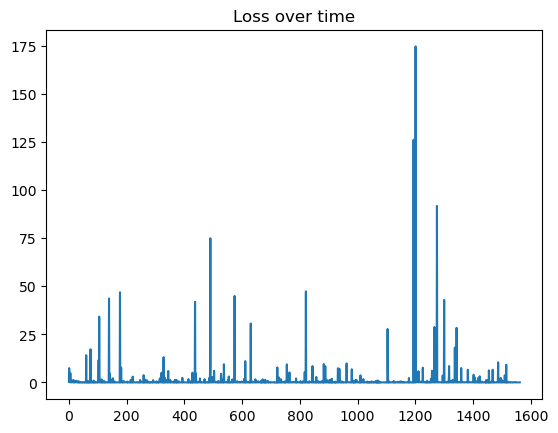

In [8]:
epochs = 1
model = HNN(12,"Feedforward")
opt = torch.optim.Adam(model.parameters(),1e-3)
losses = []
for epoch in range(epochs):
    for x,dxdt in tqdm(dloader):
        opt.zero_grad()
        pred = model.time_derivative(x)
        loss = F.mse_loss(pred,dxdt)
        loss.backward()
        opt.step()
        losses.append(loss.item())
plt.plot(losses)
plt.title("Loss over time")
plt.show()

### Visualizing results

/tmp/ipykernel_138063/19698718.py:57: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(positions[i, j, 0], positions[i, j, 1])
/tmp/ipykernel_138063/19698718.py:61: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_approx.set_data(positions_approx[i, j, 0], positions_approx[i, j, 1])


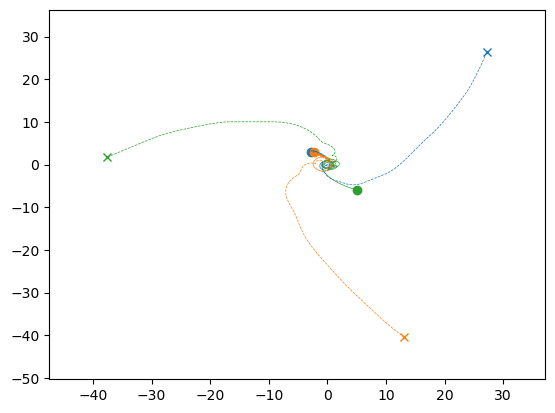

In [9]:
def model_update(t, state, model):
    state = state.reshape(-1,5)

    deriv = np.zeros_like(state)
    np_x = state[:,1:] # drop mass
    np_x = np_x.T.flatten()[None, :]
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_derivative(x)
    deriv[:,1:] = dx_hat.detach().data.numpy().reshape(4,3).T
    return deriv.reshape(-1)
num_steps = 1000
time_span = [0,40]
file_name = "vanilla_nn_example"
update_fn = lambda t, y0: model_update(t, y0, model)
state = random_config(nu=1e-2, min_radius=.9, max_radius=1.2)
v, settings = get_orbit(state, t_points=num_steps, t_span=time_span, update_fn=update_fn)
true_orbit,_ =get_orbit(state, t_points=num_steps, t_span=time_span)


positions_approx = v.transpose(2,0,1)[:,:,1:3]
positions= true_orbit.transpose(2,0,1)[:,:,1:3]
# Animation
# Animation setup
fig, ax = plt.subplots()
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)

# Original positions visualized with 'o' markers and solid lines for trajectories
lines = [ax.plot([], [], 'o')[0] for _ in range(3)]
# Store colors for reuse with approximated trajectories
colors = [f"C{_}" for _ in range(3)]
trajectories = [ax.plot([], [], '-', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

# Approximated positions visualized with 'x' markers and dotted lines for trajectories
# Use the same colors as the original trajectories
lines_approx = [ax.plot([], [], 'x', color=colors[_])[0] for _ in range(3)]
trajectories_approx = [ax.plot([], [], '--', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

def init():
    for line in lines + lines_approx:
        line.set_data([], [])
    for traj in trajectories + trajectories_approx:
        traj.set_data([], [])
    return lines + trajectories + lines_approx + trajectories_approx

def animate(i):
    if len(positions[:i,:,0]) != 0:
        all_x = np.concatenate((positions[:i, :, 0].flatten(), positions_approx[:i, :, 0].flatten()))
        all_y = np.concatenate((positions[:i, :, 1].flatten(), positions_approx[:i, :, 1].flatten()))
        min_x, max_x = all_x.min() - 10, all_x.max() + 10
        min_y, max_y = all_y.min() - 10, all_y.max() + 10
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)

    for j, (line, line_approx) in enumerate(zip(lines, lines_approx)):
        # Update original positions and trajectories
        line.set_data(positions[i, j, 0], positions[i, j, 1])
        trajectories[j].set_data(positions[:i, j, 0], positions[:i, j, 1])
        
        # Update approximated positions and trajectories
        line_approx.set_data(positions_approx[i, j, 0], positions_approx[i, j, 1])
        trajectories_approx[j].set_data(positions_approx[:i, j, 0], positions_approx[:i, j, 1])

    return lines + trajectories + lines_approx + trajectories_approx

# Assuming num_steps is defined
ani = animation.FuncAnimation(fig, animate, frames=num_steps, init_func=init, blit=True, interval=1)

# To save the animation
writergif = animation.PillowWriter(fps=30)
ani.save(f'{file_name}.gif', writer=writergif)

plt.show()

### Discussion
Typically both the Hamiltonian and Regular Neural Network did a very poor job at predicting position. This is most likely due to the chaotic nature of the system. Also, it seems like it is likely just memorizing individual paths. So when it comes to generalization, the model does not perform very well at all. At test time, it only seems to be averaging over learned paths.

Note that in these visualizations. The solid circles represent the actual trajectories and the crosses represent the predictions.

#### Feedforward Neural Network Version
![](examples/vanilla_nn_example.gif)

#### Hamiltonian Version
![](examples/hamiltonian_example_no_symmetry.gif)

# Equivariant Hamiltonian
We now implement a version of the Hamiltonian that has the added invariances/equivariances present in the problem.

The first invariance we add is invariance under translation. The velocities and accelerations of the three planets only depend on relative positions to one another. So to incorporate this invariance we pick on of the bodies and subtract the positions of the other two from this original. In this way we shift the planets closer to the origin. We can write this formally out as:
$$
NN(x)= \hat H(p2-p1,p3-p1,v1,v2,v3)
$$

We also add invariance under rotation. We note that while the actual positions and velocities should be equivariant, the actual hamiltonian is invariant under rotation. We can achieve rotational invarince by making the neural network a function of only the inner products between any two vectors. Written out this is:
$$
NN(x)=\hat H((\langle p_i,p_j \rangle)_{i,j=1}^3,(\langle q_i,q_j \rangle)_{i,j=1}^3,(\langle p_i,q_j \rangle)_{i,j=1}^3)
$$

Lastly, we add permutation invariance. This can be done by permuting the order in which the planets are fed into the model and then summing up the results.
$$
NN(x)=\sum_{\sigma \in S_3}\hat H(p_{\sigma(1)},p_{\sigma(2)},p_{\sigma(3)},q_{\sigma(1)},q_{\sigma(2)},q_{\sigma(3)})
$$

We combine each of these three methods to produce the result below. 

In [10]:
from itertools import permutations
class EquivariantHNN(torch.nn.Module):
    """Generic class to implement predicting the derivative of the three body system
    """
    def __init__(self, input_dim):
        super(EquivariantHNN, self).__init__()
        self.layers = nn.Sequential(nn.Linear(15,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,1))

        # We make a permutation matrix M to later permute the derivatives so our loss acheives:
        # dp/dt=-dH/dq, dq/dt=dH/dp
        M = torch.eye(input_dim)
        self.M = torch.cat([M[input_dim//2:], -M[:input_dim//2]]) 

    def equivariant_fn(self,x):
        # print(x.shape)
        p1 = x[:,[True,False,False,True,False,False]+[False]*6]
        p2 = x[:,[False,True,False,False,True,False]+[False]*6]
        p3 = x[:,[False,False,True,False,False,True]+[False]*6]
        s1 = x[:,[False]*6+[True,False,False,True,False,False]]
        s2 = x[:,[False]*6+[False,True,False,False,True,False]]
        s3 = x[:,[False]*6+[False,False,True,False,False,True]]

        ps = [p1,p2,p3]
        ss = [s1,s2,s3]
        perms = permutations([1,2,0])

        # Cycling through each permutation ensures invariance under permutation
        outs = 0
        for perm in perms:
            # print(perm)
            p_1,p_2,p_3 = ps[perm[0]],ps[perm[1]],ps[perm[2]]
            s_1,s_2,s_3 = ss[perm[0]],ss[perm[1]],ss[perm[2]]

            # This ensures invariance under translation
            p_2 =p2- p_1
            p_3 = p_3-p_1

            # This ensures invariance under rotation
            units = [p_2,p_3,s_1,s_2,s_3]
            inner_prods = []
            for i  in range(len(units)):
                for j in range(i,len(units)):
                    inner_prods.append((units[i]*units[j]).sum(dim=-1))
            inner_prods = torch.dstack(inner_prods).squeeze(0)
            outs+= self.layers(inner_prods)
        return outs/6

    def forward(self, x):
        # We just pass it through the layers
        return self.equivariant_fn(x)

    def time_derivative(self, x, t=None):
        """Returns the prediction of our function

        Args:
            x (torch.Tensor): The state of the system
            t (torch.Tensor, optional): The current time step. Defaults to None.
        """

        # We calculate -dH/dq as our prediction for dp/dt and dH/dp as our prediction for dq/dt
        F2 = self.forward(x) 

        dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] 
        hamiltonian_derivative = dF2 @ self.M.T

        return hamiltonian_derivative

### Loss and Training results
Below we plot the training loss over time of both the acceleration and velocity. This is done to figure out which component is harder for the model to learn.

100%|██████████| 1563/1563 [02:42<00:00,  9.62it/s]


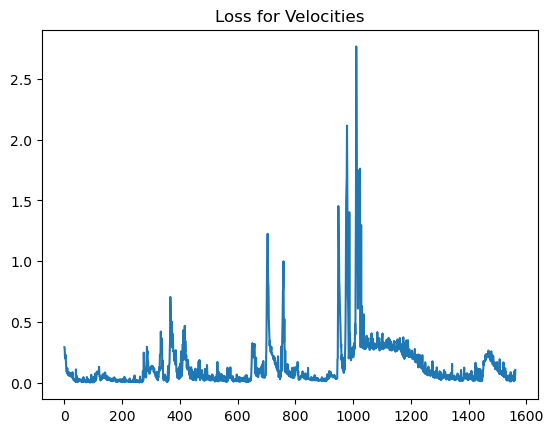

Text(0.5, 1.0, 'Loss for Accelerations')

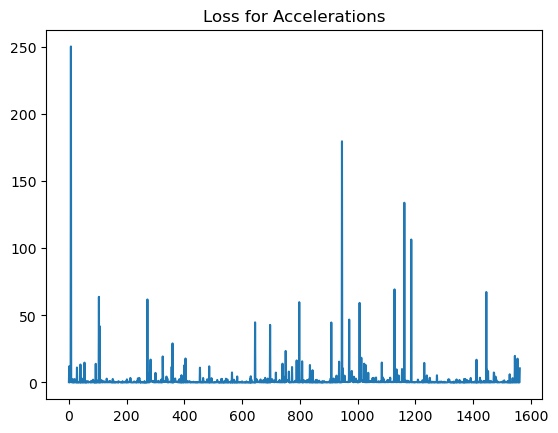

In [12]:
epochs = 1
model = EquivariantHNN(12)
opt = torch.optim.Adam(model.parameters(),1e-3)
losses1 = []
losses2 = []
for epoch in range(epochs):
    for x,dxdt in tqdm(dloader):
        opt.zero_grad()
        pred = model.time_derivative(x)
        loss1 = F.mse_loss(pred[:,:3],dxdt[:,:3])
        loss2= F.mse_loss(pred[:,3:],dxdt[:,3:])
        loss = loss1+loss2**2
        loss.backward()
        opt.step()
        losses1.append(loss1.item())
        losses2.append(loss2.item())
plt.plot(losses1)
plt.title("Loss for Velocities")
plt.show()
plt.plot(losses2)
plt.title("Loss for Accelerations")

/tmp/ipykernel_138063/1772924157.py:57: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(positions[i, j, 0], positions[i, j, 1])
/tmp/ipykernel_138063/1772924157.py:61: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line_approx.set_data(positions_approx[i, j, 0], positions_approx[i, j, 1])


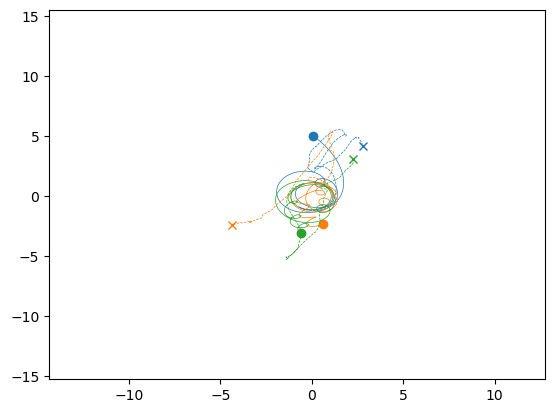

In [13]:
def model_update(t, state, model):
    state = state.reshape(-1,5)

    deriv = np.zeros_like(state)
    np_x = state[:,1:] # drop mass
    np_x = np_x.T.flatten()[None, :]
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_derivative(x)
    deriv[:,1:] = dx_hat.detach().data.numpy().reshape(4,3).T
    return deriv.reshape(-1)
num_steps = 500
time_span = [0,40]
file_name = "equivariant_hnn"
update_fn = lambda t, y0: model_update(t, y0, model)
state = random_config(nu=1e-2, min_radius=.9, max_radius=1.2)
v, settings = get_orbit(state, t_points=num_steps, t_span=time_span, update_fn=update_fn)
true_orbit,_ =get_orbit(state, t_points=num_steps, t_span=time_span)


positions_approx = v.transpose(2,0,1)[:,:,1:3]
positions= true_orbit.transpose(2,0,1)[:,:,1:3]
# Animation
# Animation setup
fig, ax = plt.subplots()
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)

# Original positions visualized with 'o' markers and solid lines for trajectories
lines = [ax.plot([], [], 'o')[0] for _ in range(3)]
# Store colors for reuse with approximated trajectories
colors = [f"C{_}" for _ in range(3)]
trajectories = [ax.plot([], [], '-', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

# Approximated positions visualized with 'x' markers and dotted lines for trajectories
# Use the same colors as the original trajectories
lines_approx = [ax.plot([], [], 'x', color=colors[_])[0] for _ in range(3)]
trajectories_approx = [ax.plot([], [], '--', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

def init():
    for line in lines + lines_approx:
        line.set_data([], [])
    for traj in trajectories + trajectories_approx:
        traj.set_data([], [])
    return lines + trajectories + lines_approx + trajectories_approx

def animate(i):
    if len(positions[:i,:,0]) != 0:
        all_x = np.concatenate((positions[:i, :, 0].flatten(), positions_approx[:i, :, 0].flatten()))
        all_y = np.concatenate((positions[:i, :, 1].flatten(), positions_approx[:i, :, 1].flatten()))
        min_x, max_x = all_x.min() - 10, all_x.max() + 10
        min_y, max_y = all_y.min() - 10, all_y.max() + 10
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)

    for j, (line, line_approx) in enumerate(zip(lines, lines_approx)):
        # Update original positions and trajectories
        line.set_data(positions[i, j, 0], positions[i, j, 1])
        trajectories[j].set_data(positions[:i, j, 0], positions[:i, j, 1])
        
        # Update approximated positions and trajectories
        line_approx.set_data(positions_approx[i, j, 0], positions_approx[i, j, 1])
        trajectories_approx[j].set_data(positions_approx[:i, j, 0], positions_approx[:i, j, 1])

    return lines + trajectories + lines_approx + trajectories_approx

# Assuming num_steps is defined
ani = animation.FuncAnimation(fig, animate, frames=num_steps, init_func=init, blit=True, interval=1)

# To save the animation
writergif = animation.PillowWriter(fps=30)
ani.save(f'{file_name}.gif', writer=writergif)

plt.show()

### Discussion
The Equivariant Hamiltonian acheived much better results on test data than the non equivariant versions. It could predict an accurate path for the first second or so. However, once we got past the initial couple of seconds it would completely diverge from the true path and not seem to model accurate paths at all.

Note that in these visualizations. The solid circles represent the actual trajectories and the crosses represent the predictions.

![](examples/equivariant_hnn.gif)

# Neural ODE
A Neural ODE works by treating a Neural Network $f$ as a derivative in some differential equation. We then use an ODE solver to integrate forward in time and then backpropagate through the ODE solver. This can be viewed as smoothing or continuizing the normal feedforward network since we can arbitrarily choose the step size.

These most direct implementations of a Neural ODE below incorporate the most symmetries. The first implementation defines the derivative of position to be the velocity, assumes the derivative of velocity is only dependent on position, and incorporates both conservation of momentum and permutation symmetry.

The permutation symmetry is accomplished by running the model on all six permutations of the inputs. Instead of predicting the trajectories for all three bodies, each permutation only predicts one body. All six permutations therefore predict a total of six different bodies. The trajectories (or more properly the accelerations) are then averaged to produce only three bodies in a way that is permutation invariant. All of these symmetries are incorporated using carefully chosen tensor products.

  0%|          | 0/5000 [00:00<?, ?it/s]

  1%|          | 50/5000 [00:26<40:22,  2.04it/s]

Iter: 50, running avg elbo: -0.8080, loss


  2%|▏         | 100/5000 [00:51<39:39,  2.06it/s]

Iter: 100, running avg elbo: -0.7399, loss


  3%|▎         | 150/5000 [01:15<37:56,  2.13it/s]

Iter: 150, running avg elbo: -0.7156, loss


  4%|▍         | 200/5000 [01:39<38:52,  2.06it/s]

Iter: 200, running avg elbo: -0.7011, loss


  5%|▌         | 250/5000 [02:02<37:59,  2.08it/s]

Iter: 250, running avg elbo: -0.6915, loss


  6%|▌         | 300/5000 [02:24<34:58,  2.24it/s]

Iter: 300, running avg elbo: -0.6855, loss


  7%|▋         | 350/5000 [02:46<33:33,  2.31it/s]

Iter: 350, running avg elbo: -0.6806, loss


  8%|▊         | 400/5000 [03:08<32:33,  2.35it/s]

Iter: 400, running avg elbo: -0.6769, loss


  9%|▉         | 450/5000 [03:30<34:06,  2.22it/s]

Iter: 450, running avg elbo: -0.6732, loss


 10%|█         | 500/5000 [03:51<31:25,  2.39it/s]

Iter: 500, running avg elbo: -0.6703, loss


 11%|█         | 550/5000 [04:13<31:06,  2.38it/s]

Iter: 550, running avg elbo: -0.6679, loss


 12%|█▏        | 600/5000 [04:34<31:26,  2.33it/s]

Iter: 600, running avg elbo: -0.6663, loss


 13%|█▎        | 650/5000 [04:55<30:12,  2.40it/s]

Iter: 650, running avg elbo: -0.6645, loss


 14%|█▍        | 700/5000 [05:16<30:19,  2.36it/s]

Iter: 700, running avg elbo: -0.6626, loss


 15%|█▌        | 750/5000 [05:38<30:16,  2.34it/s]

Iter: 750, running avg elbo: -0.6610, loss


 16%|█▌        | 800/5000 [05:59<29:46,  2.35it/s]

Iter: 800, running avg elbo: -0.6596, loss


 17%|█▋        | 850/5000 [06:20<29:09,  2.37it/s]

Iter: 850, running avg elbo: -0.6581, loss


 18%|█▊        | 900/5000 [06:41<29:01,  2.35it/s]

Iter: 900, running avg elbo: -0.6568, loss


 19%|█▉        | 950/5000 [07:02<28:08,  2.40it/s]

Iter: 950, running avg elbo: -0.6553, loss


 20%|██        | 1000/5000 [07:40<5:58:11,  5.37s/it]

Iter: 1000, running avg elbo: -0.6540, loss


 21%|██        | 1050/5000 [08:01<27:55,  2.36it/s]  

Iter: 1050, running avg elbo: -0.6527, loss


 22%|██▏       | 1100/5000 [08:22<27:51,  2.33it/s]

Iter: 1100, running avg elbo: -0.6515, loss


 23%|██▎       | 1150/5000 [08:43<26:37,  2.41it/s]

Iter: 1150, running avg elbo: -0.6505, loss


 24%|██▍       | 1200/5000 [09:04<26:15,  2.41it/s]

Iter: 1200, running avg elbo: -0.6493, loss


 25%|██▌       | 1250/5000 [09:25<27:15,  2.29it/s]

Iter: 1250, running avg elbo: -0.6481, loss


 26%|██▌       | 1300/5000 [09:46<27:45,  2.22it/s]

Iter: 1300, running avg elbo: -0.6470, loss


 27%|██▋       | 1350/5000 [10:07<26:43,  2.28it/s]

Iter: 1350, running avg elbo: -0.6461, loss


 28%|██▊       | 1400/5000 [10:29<27:08,  2.21it/s]

Iter: 1400, running avg elbo: -0.6450, loss


 29%|██▉       | 1450/5000 [10:50<25:09,  2.35it/s]

Iter: 1450, running avg elbo: -0.6440, loss


 30%|███       | 1500/5000 [11:11<24:48,  2.35it/s]

Iter: 1500, running avg elbo: -0.6429, loss


 31%|███       | 1550/5000 [11:33<24:31,  2.34it/s]

Iter: 1550, running avg elbo: -0.6422, loss


 32%|███▏      | 1600/5000 [11:55<23:19,  2.43it/s]

Iter: 1600, running avg elbo: -0.6416, loss


 33%|███▎      | 1650/5000 [12:16<24:04,  2.32it/s]

Iter: 1650, running avg elbo: -0.6408, loss


 34%|███▍      | 1700/5000 [12:37<23:07,  2.38it/s]

Iter: 1700, running avg elbo: -0.6401, loss


 35%|███▌      | 1750/5000 [12:59<23:28,  2.31it/s]

Iter: 1750, running avg elbo: -0.6392, loss


 36%|███▌      | 1800/5000 [13:21<22:35,  2.36it/s]

Iter: 1800, running avg elbo: -0.6383, loss


 37%|███▋      | 1850/5000 [13:43<22:28,  2.34it/s]

Iter: 1850, running avg elbo: -0.6374, loss


 38%|███▊      | 1900/5000 [14:05<22:13,  2.33it/s]

Iter: 1900, running avg elbo: -0.6367, loss


 39%|███▉      | 1950/5000 [14:27<21:32,  2.36it/s]

Iter: 1950, running avg elbo: -0.6359, loss


 40%|████      | 2000/5000 [15:05<4:25:40,  5.31s/it]

Iter: 2000, running avg elbo: -0.6351, loss


 41%|████      | 2050/5000 [15:26<20:38,  2.38it/s]  

Iter: 2050, running avg elbo: -0.6346, loss


 42%|████▏     | 2100/5000 [15:49<22:08,  2.18it/s]

Iter: 2100, running avg elbo: -0.6339, loss


 43%|████▎     | 2150/5000 [16:11<21:17,  2.23it/s]

Iter: 2150, running avg elbo: -0.6334, loss


 44%|████▍     | 2200/5000 [16:34<21:00,  2.22it/s]

Iter: 2200, running avg elbo: -0.6330, loss


 45%|████▌     | 2250/5000 [16:57<21:01,  2.18it/s]

Iter: 2250, running avg elbo: -0.6323, loss


 46%|████▌     | 2300/5000 [17:20<20:43,  2.17it/s]

Iter: 2300, running avg elbo: -0.6317, loss


 47%|████▋     | 2350/5000 [17:43<20:22,  2.17it/s]

Iter: 2350, running avg elbo: -0.6311, loss


 48%|████▊     | 2400/5000 [18:06<20:01,  2.16it/s]

Iter: 2400, running avg elbo: -0.6305, loss


 49%|████▉     | 2450/5000 [18:28<18:29,  2.30it/s]

Iter: 2450, running avg elbo: -0.6299, loss


 50%|█████     | 2500/5000 [18:51<19:51,  2.10it/s]

Iter: 2500, running avg elbo: -0.6293, loss


 51%|█████     | 2550/5000 [19:14<18:37,  2.19it/s]

Iter: 2550, running avg elbo: -0.6286, loss


 52%|█████▏    | 2600/5000 [19:37<18:00,  2.22it/s]

Iter: 2600, running avg elbo: -0.6281, loss


 53%|█████▎    | 2650/5000 [20:00<18:23,  2.13it/s]

Iter: 2650, running avg elbo: -0.6273, loss


 54%|█████▍    | 2700/5000 [20:23<17:46,  2.16it/s]

Iter: 2700, running avg elbo: -0.6266, loss


 55%|█████▌    | 2750/5000 [20:47<18:17,  2.05it/s]

Iter: 2750, running avg elbo: -0.6259, loss


 56%|█████▌    | 2800/5000 [21:10<16:57,  2.16it/s]

Iter: 2800, running avg elbo: -0.6255, loss


 57%|█████▋    | 2850/5000 [21:33<16:30,  2.17it/s]

Iter: 2850, running avg elbo: -0.6250, loss


 58%|█████▊    | 2900/5000 [21:57<16:34,  2.11it/s]

Iter: 2900, running avg elbo: -0.6245, loss


 59%|█████▉    | 2950/5000 [22:20<15:48,  2.16it/s]

Iter: 2950, running avg elbo: -0.6239, loss


 60%|██████    | 3000/5000 [23:00<2:59:21,  5.38s/it]

Iter: 3000, running avg elbo: -0.6234, loss


 61%|██████    | 3050/5000 [23:23<14:41,  2.21it/s]  

Iter: 3050, running avg elbo: -0.6226, loss


 62%|██████▏   | 3100/5000 [23:46<14:42,  2.15it/s]

Iter: 3100, running avg elbo: -0.6221, loss


 63%|██████▎   | 3150/5000 [24:09<14:14,  2.17it/s]

Iter: 3150, running avg elbo: -0.6215, loss


 64%|██████▍   | 3200/5000 [24:32<13:38,  2.20it/s]

Iter: 3200, running avg elbo: -0.6211, loss


 65%|██████▌   | 3250/5000 [24:55<13:18,  2.19it/s]

Iter: 3250, running avg elbo: -0.6204, loss


 66%|██████▌   | 3300/5000 [25:18<12:53,  2.20it/s]

Iter: 3300, running avg elbo: -0.6198, loss


 67%|██████▋   | 3350/5000 [25:41<12:11,  2.25it/s]

Iter: 3350, running avg elbo: -0.6193, loss


 68%|██████▊   | 3400/5000 [26:04<12:02,  2.22it/s]

Iter: 3400, running avg elbo: -0.6187, loss


 69%|██████▉   | 3450/5000 [26:27<12:00,  2.15it/s]

Iter: 3450, running avg elbo: -0.6181, loss


 70%|███████   | 3500/5000 [26:50<11:59,  2.08it/s]

Iter: 3500, running avg elbo: -0.6176, loss


 71%|███████   | 3550/5000 [27:13<11:08,  2.17it/s]

Iter: 3550, running avg elbo: -0.6170, loss


 72%|███████▏  | 3600/5000 [27:37<10:53,  2.14it/s]

Iter: 3600, running avg elbo: -0.6165, loss


 73%|███████▎  | 3650/5000 [28:00<10:30,  2.14it/s]

Iter: 3650, running avg elbo: -0.6163, loss


 74%|███████▍  | 3700/5000 [28:23<10:00,  2.17it/s]

Iter: 3700, running avg elbo: -0.6157, loss


 75%|███████▌  | 3750/5000 [28:47<09:41,  2.15it/s]

Iter: 3750, running avg elbo: -0.6153, loss


 76%|███████▌  | 3800/5000 [29:11<11:45,  1.70it/s]

Iter: 3800, running avg elbo: -0.6148, loss


 77%|███████▋  | 3850/5000 [29:37<08:35,  2.23it/s]

Iter: 3850, running avg elbo: -0.6144, loss


 78%|███████▊  | 3900/5000 [30:01<08:46,  2.09it/s]

Iter: 3900, running avg elbo: -0.6140, loss


 79%|███████▉  | 3950/5000 [30:25<08:13,  2.13it/s]

Iter: 3950, running avg elbo: -0.6137, loss


 80%|████████  | 4000/5000 [31:05<1:29:01,  5.34s/it]

Iter: 4000, running avg elbo: -0.6133, loss


 81%|████████  | 4050/5000 [31:29<07:25,  2.13it/s]  

Iter: 4050, running avg elbo: -0.6128, loss


 82%|████████▏ | 4100/5000 [31:54<07:38,  1.96it/s]

Iter: 4100, running avg elbo: -0.6123, loss


 83%|████████▎ | 4150/5000 [32:17<06:27,  2.19it/s]

Iter: 4150, running avg elbo: -0.6119, loss


 84%|████████▍ | 4200/5000 [32:41<06:23,  2.09it/s]

Iter: 4200, running avg elbo: -0.6115, loss


 85%|████████▌ | 4250/5000 [33:05<06:31,  1.91it/s]

Iter: 4250, running avg elbo: -0.6110, loss


 86%|████████▌ | 4300/5000 [33:31<05:58,  1.95it/s]

Iter: 4300, running avg elbo: -0.6106, loss


 87%|████████▋ | 4350/5000 [33:55<05:18,  2.04it/s]

Iter: 4350, running avg elbo: -0.6102, loss


 88%|████████▊ | 4400/5000 [34:22<06:19,  1.58it/s]

Iter: 4400, running avg elbo: -0.6098, loss


 89%|████████▉ | 4450/5000 [34:47<04:21,  2.10it/s]

Iter: 4450, running avg elbo: -0.6094, loss


 90%|█████████ | 4500/5000 [35:11<04:01,  2.07it/s]

Iter: 4500, running avg elbo: -0.6089, loss


 91%|█████████ | 4550/5000 [35:36<03:40,  2.04it/s]

Iter: 4550, running avg elbo: -0.6086, loss


 92%|█████████▏| 4600/5000 [36:03<03:25,  1.94it/s]

Iter: 4600, running avg elbo: -0.6082, loss


 93%|█████████▎| 4650/5000 [36:30<03:08,  1.85it/s]

Iter: 4650, running avg elbo: -0.6079, loss


 94%|█████████▍| 4700/5000 [36:56<02:28,  2.02it/s]

Iter: 4700, running avg elbo: -0.6075, loss


 95%|█████████▌| 4750/5000 [37:20<02:01,  2.06it/s]

Iter: 4750, running avg elbo: -0.6073, loss


 96%|█████████▌| 4800/5000 [37:45<01:37,  2.04it/s]

Iter: 4800, running avg elbo: -0.6070, loss


 97%|█████████▋| 4850/5000 [38:10<01:13,  2.04it/s]

Iter: 4850, running avg elbo: -0.6066, loss


 98%|█████████▊| 4900/5000 [38:34<00:50,  1.98it/s]

Iter: 4900, running avg elbo: -0.6062, loss


 99%|█████████▉| 4950/5000 [38:59<00:24,  2.03it/s]

Iter: 4950, running avg elbo: -0.6059, loss


100%|██████████| 5000/5000 [39:41<00:00,  2.10it/s]

Iter: 5000, running avg elbo: -0.6057, loss


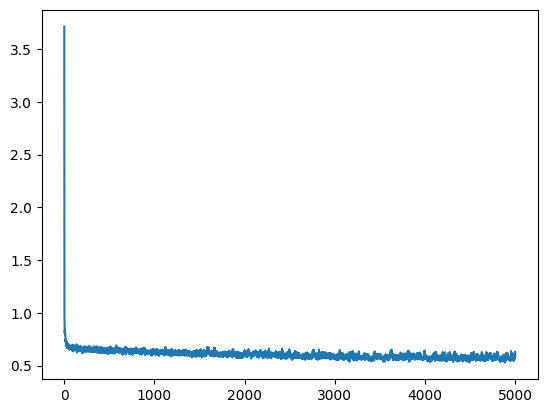

In [25]:
from matplotlib.animation import FuncAnimation, PillowWriter

def animate_trajectories_with_tips(pred_x, x, batch, filepath="/mnt/data/trajectory_animation_with_tips.gif", fps=20):
    """
    Animate and save the trajectories of predicted and true positions with balls at the tips.

    Parameters:
    - pred_x: Predicted trajectories, expected shape (1, T, 6).
    - x: True trajectories, expected shape (1, T, 6).
    - batch: Index of the batch for which to plot the trajectories.
    - filepath: Path to save the animation GIF.
    - fps: Frames per second for the animation.
    """
    T = pred_x.shape[1]  # Number of time steps

    fig, ax = plt.subplots()

    # Initialize lines for predicted (dashed) and true (solid) trajectories
    lines = [plt.plot([], [], "--", color=f"C{i}")[0] for i in range(3)] + \
            [plt.plot([], [], "-", color=f"C{i}")[0] for i in range(3)]
    # Initialize markers for the tips of each trajectory
    markers = [plt.plot([], [], 'x', color=f"C{i}")[0] for i in range(3)]+[plt.plot([], [], 'o', color=f"C{i}")[0] for i in range(3)]
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    def init():
        for line in lines:
            line.set_data([], [])
        for marker in markers:
            marker.set_data([], [])
        return lines + markers

    def update(frame):
        for i in range(3):
            # Update predicted trajectories
            lines[i].set_data(pred_x[0, :frame, i], pred_x[0, :frame, i+3])
            # Update markers for predicted trajectories
            markers[i].set_data(pred_x[0, frame-1, i], pred_x[0, frame-1, i+3])
            
            # Update true trajectories
            lines[i+3].set_data(x[batch][ 0, :frame, i], x[batch][ 0, :frame, i+3])
            # Update markers for true trajectories
            markers[i+3].set_data(x[batch][ 0, frame-1, i], x[batch][0, frame-1, i+3])
        return lines + markers

    ani = FuncAnimation(fig, update, frames=np.arange(1, T+1), init_func=init, blit=True)

    # Save the animation as a GIF
    writer = PillowWriter(fps=fps)
    ani.save(filepath, writer=writer)

    plt.close(fig)  # Close the figure to avoid displaying it in a Jupyter notebook or similar environment

class SymmetricNeuralODE(nn.Module):
    def __init__(self, hidden_dim, hidden_depth):
        super().__init__()
        self.odefunc = mlp(
            input_dim = 6,
            hidden_dim = hidden_dim,
            output_dim = 2,
            hidden_depth = hidden_depth
        )
        self.input_weight = torch.Tensor([
    [
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]

    ],
    [
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]
    ],
    [
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]
    ],
    [
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1]
    ],
    [
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0]
    ],
    [
        [0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 1, 0, 0, 0],
        [0, 0, 0, 1, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0, 0]
    ]
        ]).float()
        self.output_weight = torch.Tensor([
    [2, 2, -1, -1, -1, -1],
    [-1, -1, 2, 2, -1, -1],
    [-1, -1, -1, -1, 2, 2]
        ]).float()

        def init(m):
            if isinstance(m, nn.Linear):
                std = 1.0 / np.sqrt(m.weight.size(1))
                m.weight.data.uniform_(-2.0 * std, 2.0 * std)
                m.bias.data.zero_()

        self.odefunc.apply(init)

    def forward(self, t, state):
        return torch.cat((state[:,6:], torch.matmul(self.output_weight, self.odefunc((self.input_weight @ state[:,:6].T).permute(2, 0, 1))).view(-1, 6)), dim = 1)
        

        
        

    def simulate(self, state, times):
        solution = todeint(self, state, times, atol=1e-5, rtol=1e-5, method="dopri5", options = {"dtype": torch.float32})
        # B, S, T
        return solution

def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None, act=nn.ReLU):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), act()]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), act()]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

fname = "grouped_data_longer"
if not os.path.isfile(f"{fname}_x_coords.pt"):

    data,_ = sample_orbits_grouped(timesteps = 500,trials = 5000,t_span=[0,20])
    x = torch.tensor( data['coords'], requires_grad=True, dtype=torch.float32)
    # test_x = torch.tensor( data['test_coords'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.Tensor(data['dcoords'])
    torch.save(x,f"{fname}_x_coords.pt")
    torch.save(dxdt,f"{fname}_dxdt_vals.pt")
else:
    x = torch.load(f"{fname}_x_coords.pt")
    dxdt = torch.load(f"{fname}_dxdt_vals.pt")

fname = "permuted_node"
permutation_model = SymmetricNeuralODE(32, 8)
optimizer = torch.optim.Adam(permutation_model.parameters(), lr = 5e-3)
losses = []
epochs = 5000
batch_size = 100
device = torch.device("cpu")

for itr in tqdm(range(1, epochs + 1)):
    optimizer.zero_grad()

    # Get the batch
    #batch = torch.arange(len(x))[:1]
    batch = torch.randperm(len(x))[:batch_size].to(device)

    obs = x[batch, 0, :]
    times = torch.linspace(0, 20, 500)
    permuter = torch.Tensor([0,3,1,4,2,5,6,9,7,10,8,11]).long()
    trajectory = torch.permute(permutation_model.simulate(obs[:,permuter], times), (1, 0, 2))
    permuter = torch.Tensor([0,2,4,1,3,5,6,8,10,7,9,11]).long()
    trajectory = trajectory[:,:,permuter]

    # We now animate is
    if itr % 1000 ==0:
        animate_trajectories_with_tips(trajectory.detach().cpu(),x.detach().cpu(),batch.detach().cpu(),fname+".gif")


    # Calculate the exact loss
    loss = (torch.abs(trajectory-x[batch]).mean())
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if itr % 50 == 0:
        print('Iter: {}, running avg elbo: {:.4f}, loss'.format(itr, -np.mean(losses)))
plt.clf()
plt.plot(losses)
plt.savefig(fname + ".png")



In [28]:
data,_ = sample_orbits_grouped(timesteps = 500,trials = 1,t_span=[0,20])
batch = torch.arange(1)
x = torch.tensor( data['coords'], requires_grad=True, dtype=torch.float32)
obs = x[batch, 0, :]
times = torch.linspace(0, 20, 500)
permuter = torch.Tensor([0,3,1,4,2,5,6,9,7,10,8,11]).long()
trajectory = torch.permute(permutation_model.simulate(obs[:,permuter], times), (1, 0, 2))
permuter = torch.Tensor([0,2,4,1,3,5,6,8,10,7,9,11]).long()
trajectory = trajectory[:,:,permuter]
animate_trajectories_with_tips(trajectory.detach().cpu(),x.detach().cpu(),batch.detach().cpu(),"permutation_test.gif")

Generating dataset
[..................................................] 0.00% ETA: almost done1


### Loss and Test Trajectory

The neural ODE seems to be more capable of learning the trajetories. It is interesting to note that although the model misses many of the finer parts of the trajectory, it roughly follows the general orbit. The loss steadily improved and could probably be further improved if the model were trained for longer.

![](figures/permuted_node.png)
![](figures/permutation_test.gif)

This next model also incorporates translational and rotational symmetry. In the previous model, the three positions were taken as input (totaling a six dimensional input). To incorportate translational invariance (of acceleration), the first position is subtracted from the other two and then discarded, reducing the input dimension to 4. To incorporate rotational symmetry, the model receives as input the three dot products obtained from the remaining two positions ($p_1 \cdot p_1$, $p_2 \cdot p_2$, and $p_1 \cdot p_2$). The input dimension is therefore only 3. The output dimensions is then two coefficients $\alpha_1$ and $\alpha_2$ that output the acceleration $\alpha_1 p_1 + \alpha_2 p_2$. Again, all these symmetries are done using carefully chosen tensor products. To test the symmetries, we tested the real acceleration in place of our model (still using all the tensor products to induce symmetries) and found that it predicted the orbits perfectly (accounting for numerical error). Unfornately, this model was incredibly unstable while training, quickly resulting in underflow errors. We changed the integration method to dopri8, reduced the tolerances, and made the symmetries optional but setting the symmetry tensors as parameters. Interestingly, the model started training much faster when the symmetries are not enforced. The first model below enforces symmetries, and the second does not.

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 20/1000 [00:12<09:21,  1.75it/s]

Iter: 20, running avg elbo: -0.7807


  4%|▍         | 40/1000 [00:26<11:36,  1.38it/s]

Iter: 40, running avg elbo: -0.7695


  6%|▌         | 60/1000 [00:41<11:48,  1.33it/s]

Iter: 60, running avg elbo: -0.7633


  8%|▊         | 80/1000 [00:56<10:47,  1.42it/s]

Iter: 80, running avg elbo: -0.7610


 10%|█         | 100/1000 [01:12<12:47,  1.17it/s]

Iter: 100, running avg elbo: -0.7590


 12%|█▏        | 120/1000 [01:28<15:25,  1.05s/it]

Iter: 120, running avg elbo: -0.7580


 14%|█▎        | 135/1000 [01:46<11:20,  1.27it/s]


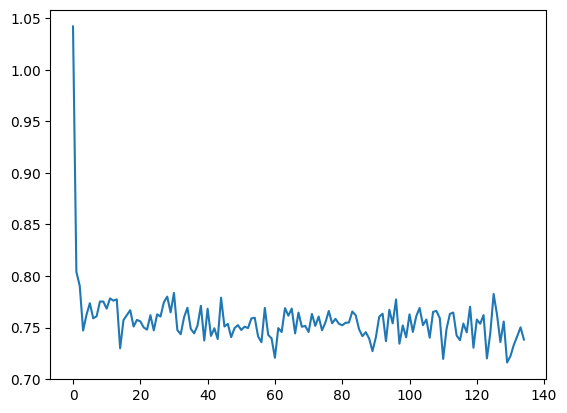

In [76]:
ideal_input = torch.Tensor([
    [
        [1, 1, 0, 0, 0, -2],
        [1, 0, 1, 0, -2, 0],
        [1, 0, 0, 1, -1, -1]

    ],
    [
        [1, 0, 1, 0, -2, 0],
        [1, 1, 0, 0, 0, -2],
        [1, 0, 0, 1, -1, -1]
    ],
    [
        [0, 1, 1, -2, 0, 0],
        [1, 1, 0, 0, 0, -2],
        [0, 1, 0, -1, 1, -1]
    ],
    [
        [1, 1, 0, 0, 0, -2],
        [0, 1, 1, -2, 0, 0],
        [0, 1, 0, -1, 1, -1]
    ],
    [
        [1, 0, 1, 0, -2, 0],
        [0, 1, 1, -2, 0, 0],
        [0, 0, 1, -1, -1, 1]
    ],
    [
        [0, 1, 1, -2, 0, 0],
        [1, 0, 1, 0, -2, 0],
        [0, 0, 1, -1, -1, 1]
    ]
        ]).float()

ideal_output1 = torch.Tensor([
            [1, 0],
            [0, 1],
            [0, 1],
            [1, 0]
        ]).float()

ideal_output2 = torch.Tensor([
    [
        [-1,-1,0,0,0,0],
        [1,0,0,0,0,0],
        [0,1,0,0,0,0]
    ],
    [
        [0,0,0,1,0,0],
        [0,0,-1,-1,0,0],
        [0,0,1,0,0,0]
    ],
    [
        [0,0,0,0,1,0],
        [0,0,0,0,0,1],
        [0,0,0,0,-1,-1]
    ],
        ]).float()

ideal_output3 = torch.Tensor([
            [2, -1, -1],
            [-1, 2, -1],
            [-1, -1, 2]
        ]).float()

class mlp_helper(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_depth, skip_regularity):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.hidden_depth = hidden_depth
        self.skip_regularity = skip_regularity

        self.layers = nn.ParameterList([nn.Linear(input_dim, hidden_dim)])
        for i in range(hidden_depth - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))

        def initial(m):
            if isinstance(m, nn.Linear):
                std = 1.0 / np.sqrt(m.weight.size(1))
                m.weight.data.uniform_(-2.0 * std, 2.0 * std)
                m.bias.data.zero_()

        for layer in self.layers:
            initial(layer)
    def forward(self, x):
        act = nn.ReLU()
        hidden = act(self.layers[0](x))
        saved = hidden
        for i in range(1, self.hidden_depth):
            hidden = act(self.layers[i](hidden))
            if i % self.skip_regularity == 0:
                hidden = hidden + saved
                saved = hidden
        return self.layers[self.hidden_depth](hidden)

class EquivariantNeuralODE(nn.Module):
    def __init__(self, hidden_dim, hidden_depth, skip_regularity, freeze_symmetry):
        super().__init__()
        self.odefunc = mlp_helper(
            input_dim = 3,
            hidden_dim = hidden_dim,
            output_dim = 2,
            hidden_depth = hidden_depth,
            skip_regularity = skip_regularity
        )
        # Input permutations
        self.input_weight = nn.Parameter(torch.Tensor(ideal_input).float())
        # Swapping symmetry
        self.output_weight1 = nn.Parameter(torch.Tensor(ideal_output1).float())
        # Cycling symmetry
        self.output_weight2 = nn.Parameter(torch.Tensor(ideal_output2).float())
        # Conservation of momentum
        self.output_weight3 = nn.Parameter(torch.Tensor(ideal_output3).float())

        if freeze_symmetry:
            self.input_weight.requires_grad = False
            self.output_weight1.requires_grad = False
            self.output_weight2.requires_grad = False
            self.output_weight3.requires_grad = False

        def init(m):
            if isinstance(m, nn.Linear):
                std = 1.0 / np.sqrt(m.weight.size(1) * hidden_depth)
                m.weight.data.uniform_(-2.0 * std, 2.0 * std)
                m.bias.data.zero_()

        self.odefunc.apply(init)

    def func2(self, x):
        return torch.stack((1/(6*x[:,:,0]**1.5), 1/(6*x[:,:,1]**1.5)), dim = -1)

    def forward(self, t, state):
       p1 = state[:,:2]
       p2 = state[:,2:4]
       p3 = state[:,4:6]

       d11 = torch.sum(p1 * p1, dim = -1)
       d22 = torch.sum(p2 * p2, dim = -1)
       d33 = torch.sum(p3 * p3, dim = -1)
       d12 = torch.sum(p1 * p2, dim = -1)
       d23 = torch.sum(p2 * p3, dim = -1)
       d31 = torch.sum(p3 * p1, dim = -1)

       d = torch.stack((d11,d22,d33,d23,d31,d12), dim = 0)
       output = self.odefunc((self.input_weight @ d).permute(2,0,1)).view(-1, 3, 4) @ self.output_weight1
       output2 = self.output_weight3 @ (self.output_weight2 @ output.view(-1, 6).T).permute(2, 0, 1) @ torch.stack((p1, p2, p3), dim = 1)
       



       return torch.cat((state[:,6:], output2.view(-1, 6)), dim = 1)
        

        
        

    def simulate(self, state, times):
        solution = todeint(self, state, times, atol=1e-5, rtol=1e-5, method="dopri8", options = {"dtype": torch.float32})
        #solution = todeint(self, state, times, atol=1, rtol=1, method="rk4", options = {"step_size": 2e-2})
        # B, S, T
        return solution

def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None, act=nn.ReLU):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), act()]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), act()]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

fname = "grouped_data_longer"
if not os.path.isfile(f"{fname}_x_coords.pt"):

    data,_ = sample_orbits_grouped(timesteps = 500,trials = 5000,t_span=[0,20])
    x = torch.tensor( data['coords'], requires_grad=True, dtype=torch.float32)
    #test_x = torch.tensor( data['test_coords'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.Tensor(data['dcoords'])
    torch.save(x,f"{fname}_x_coords.pt")
    torch.save(dxdt,f"{fname}_dxdt_vals.pt")
else:
    x = torch.load(f"{fname}_x_coords.pt")
    dxdt = torch.load(f"{fname}_dxdt_vals.pt")

fname = "permuted_node"
equivariant_model = EquivariantNeuralODE(hidden_dim = 32, hidden_depth = 16, skip_regularity=4, freeze_symmetry = True)
optimizer = torch.optim.Adam(equivariant_model.parameters(), lr = 2e-3)
losses = []
epochs = 1000
batch_size = 100
device = torch.device("cpu")



for itr in tqdm(range(1, epochs + 1)):
    optimizer.zero_grad()

    # Get the batch
    batch = torch.randperm(len(x))[:batch_size]
    #batch = torch.arange(batch_size)

  
    obs = x[batch, 0, :]
    times = torch.linspace(0, 20, 500)
    permuter = torch.Tensor([0,3,1,4,2,5,6,9,7,10,8,11]).long()
    try:
        trajectory = torch.permute(equivariant_model.simulate(obs[:,permuter], times), (1, 0, 2))
        permuter = torch.Tensor([0,2,4,1,3,5,6,8,10,7,9,11]).long()
        trajectory = trajectory[:,:,permuter]

        # We now animate is
        if itr %200==0:
            test_data,_ = sample_orbits_grouped(timesteps = 500,trials = 1,t_span=[0,20])
            test_batch = torch.arange(1)
            test_x = torch.tensor( test_data['coords'], requires_grad=True, dtype=torch.float32)
            test_obs = test_x[test_batch, 0, :]
            test_times = torch.linspace(0, 20, 500)
            permuter = torch.Tensor([0,3,1,4,2,5,6,9,7,10,8,11]).long()
            test_trajectory = torch.permute(equivariant_model.simulate(test_obs[:,permuter], test_times), (1, 0, 2))
            permuter = torch.Tensor([0,2,4,1,3,5,6,8,10,7,9,11]).long()
            test_trajectory = test_trajectory[:,:,permuter]
            animate_trajectories_with_tips(test_trajectory.detach().cpu(),test_x.detach().cpu(),test_batch.detach().cpu(),"equivariant_test.gif")


        # Calculate the exact loss
        loss = (torch.abs(trajectory-x[batch]).mean())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if itr % 20 == 0:
            print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -np.mean(losses)))

    except AssertionError as e:
        break
        print("Integration error:", e)
        with torch.no_grad():
            for param in equivariant_model.parameters():
                param.add_(torch.randn(param.size()) * 0.1)

plt.clf()
plt.plot(losses)
plt.savefig("equivariant_model.png")

### Loss and Test Trajectory

The training of the completely symmetric neural ODE was incredibly unsteady and eventually diverged. The trajectories are rough.

![](figures/equivariant_model.png)
![](figures/equivariant_test.gif)

  0%|          | 0/1000 [00:00<?, ?it/s]

  2%|▏         | 20/1000 [00:15<11:56,  1.37it/s]

Iter: 20, running avg elbo: -0.7427


  4%|▍         | 40/1000 [00:31<12:29,  1.28it/s]

Iter: 40, running avg elbo: -0.7097


  6%|▌         | 60/1000 [00:47<12:46,  1.23it/s]

Iter: 60, running avg elbo: -0.6974


  8%|▊         | 80/1000 [01:06<15:59,  1.04s/it]

Iter: 80, running avg elbo: -0.6910


 10%|█         | 100/1000 [01:36<28:27,  1.90s/it]

Iter: 100, running avg elbo: -0.6843


 12%|█▏        | 120/1000 [02:26<39:15,  2.68s/it]

Iter: 120, running avg elbo: -0.6788


 14%|█▍        | 140/1000 [03:23<42:05,  2.94s/it]

Iter: 140, running avg elbo: -0.6732


 16%|█▌        | 160/1000 [04:23<41:39,  2.98s/it]

Iter: 160, running avg elbo: -0.6682


 18%|█▊        | 180/1000 [05:27<43:54,  3.21s/it]

Iter: 180, running avg elbo: -0.6640


 20%|█▉        | 199/1000 [06:33<48:46,  3.65s/it]

Generating dataset
[..................................................] 0.00% ETA: almost done1


 20%|██        | 200/1000 [06:52<1:49:40,  8.23s/it]

Iter: 200, running avg elbo: -0.6607


 22%|██▏       | 220/1000 [08:06<48:04,  3.70s/it]  

Iter: 220, running avg elbo: -0.6573


 24%|██▍       | 240/1000 [09:22<51:38,  4.08s/it]

Iter: 240, running avg elbo: -0.6543


 26%|██▌       | 260/1000 [10:39<46:10,  3.74s/it]

Iter: 260, running avg elbo: -0.6514


 28%|██▊       | 280/1000 [11:59<48:31,  4.04s/it]

Iter: 280, running avg elbo: -0.6488


 30%|███       | 300/1000 [13:20<46:14,  3.96s/it]

Iter: 300, running avg elbo: -0.6465


 32%|███▏      | 320/1000 [14:40<48:08,  4.25s/it]

Iter: 320, running avg elbo: -0.6444


 34%|███▍      | 340/1000 [16:05<45:04,  4.10s/it]

Iter: 340, running avg elbo: -0.6428


 36%|███▌      | 360/1000 [17:27<44:27,  4.17s/it]

Iter: 360, running avg elbo: -0.6416


 38%|███▊      | 380/1000 [18:39<35:09,  3.40s/it]

Iter: 380, running avg elbo: -0.6401


 40%|███▉      | 399/1000 [19:46<38:33,  3.85s/it]

Generating dataset
[..................................................] 0.00% ETA: almost done1


 40%|████      | 400/1000 [20:07<1:29:50,  8.98s/it]

Iter: 400, running avg elbo: -0.6386


 42%|████▏     | 420/1000 [21:25<35:47,  3.70s/it]  

Iter: 420, running avg elbo: -0.6374


 44%|████▍     | 440/1000 [22:45<37:26,  4.01s/it]

Iter: 440, running avg elbo: -0.6357


 46%|████▌     | 460/1000 [24:01<34:33,  3.84s/it]

Iter: 460, running avg elbo: -0.6341


 48%|████▊     | 480/1000 [25:20<35:10,  4.06s/it]

Iter: 480, running avg elbo: -0.6327


 50%|█████     | 500/1000 [26:40<32:08,  3.86s/it]

Iter: 500, running avg elbo: -0.6310


 52%|█████▏    | 520/1000 [28:00<31:25,  3.93s/it]

Iter: 520, running avg elbo: -0.6295


 53%|█████▎    | 531/1000 [28:50<25:28,  3.26s/it]


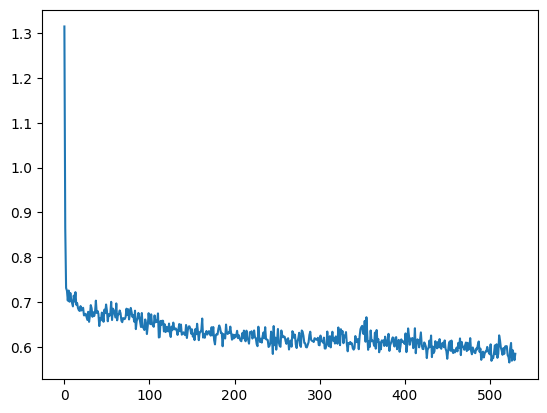

In [80]:
ideal_input = torch.Tensor([
    [
        [1, 1, 0, 0, 0, -2],
        [1, 0, 1, 0, -2, 0],
        [1, 0, 0, 1, -1, -1]

    ],
    [
        [1, 0, 1, 0, -2, 0],
        [1, 1, 0, 0, 0, -2],
        [1, 0, 0, 1, -1, -1]
    ],
    [
        [0, 1, 1, -2, 0, 0],
        [1, 1, 0, 0, 0, -2],
        [0, 1, 0, -1, 1, -1]
    ],
    [
        [1, 1, 0, 0, 0, -2],
        [0, 1, 1, -2, 0, 0],
        [0, 1, 0, -1, 1, -1]
    ],
    [
        [1, 0, 1, 0, -2, 0],
        [0, 1, 1, -2, 0, 0],
        [0, 0, 1, -1, -1, 1]
    ],
    [
        [0, 1, 1, -2, 0, 0],
        [1, 0, 1, 0, -2, 0],
        [0, 0, 1, -1, -1, 1]
    ]
        ]).float()

ideal_output1 = torch.Tensor([
            [1, 0],
            [0, 1],
            [0, 1],
            [1, 0]
        ]).float()

ideal_output2 = torch.Tensor([
    [
        [-1,-1,0,0,0,0],
        [1,0,0,0,0,0],
        [0,1,0,0,0,0]
    ],
    [
        [0,0,0,1,0,0],
        [0,0,-1,-1,0,0],
        [0,0,1,0,0,0]
    ],
    [
        [0,0,0,0,1,0],
        [0,0,0,0,0,1],
        [0,0,0,0,-1,-1]
    ],
        ]).float()

ideal_output3 = torch.Tensor([
            [2, -1, -1],
            [-1, 2, -1],
            [-1, -1, 2]
        ]).float()

class mlp_helper(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_depth, skip_regularity):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.hidden_depth = hidden_depth
        self.skip_regularity = skip_regularity

        self.layers = nn.ParameterList([nn.Linear(input_dim, hidden_dim)])
        for i in range(hidden_depth - 1):
            self.layers.append(nn.Linear(hidden_dim, hidden_dim))
        self.layers.append(nn.Linear(hidden_dim, output_dim))

        def initial(m):
            if isinstance(m, nn.Linear):
                std = 1.0 / np.sqrt(m.weight.size(1))
                m.weight.data.uniform_(-2.0 * std, 2.0 * std)
                m.bias.data.zero_()

        for layer in self.layers:
            initial(layer)
    def forward(self, x):
        act = nn.ReLU()
        hidden = act(self.layers[0](x))
        saved = hidden
        for i in range(1, self.hidden_depth):
            hidden = act(self.layers[i](hidden))
            if i % self.skip_regularity == 0:
                hidden = hidden + saved
                saved = hidden
        return self.layers[self.hidden_depth](hidden)

class EquivariantNeuralODE(nn.Module):
    def __init__(self, hidden_dim, hidden_depth, skip_regularity, freeze_symmetry):
        super().__init__()
        self.odefunc = mlp_helper(
            input_dim = 3,
            hidden_dim = hidden_dim,
            output_dim = 2,
            hidden_depth = hidden_depth,
            skip_regularity = skip_regularity
        )
        # Input permutations
        self.input_weight = nn.Parameter(torch.Tensor(ideal_input).float())
        # Swapping symmetry
        self.output_weight1 = nn.Parameter(torch.Tensor(ideal_output1).float())
        # Cycling symmetry
        self.output_weight2 = nn.Parameter(torch.Tensor(ideal_output2).float())
        # Conservation of momentum
        self.output_weight3 = nn.Parameter(torch.Tensor(ideal_output3).float())

        if freeze_symmetry:
            self.input_weight.requires_grad = False
            self.output_weight1.requires_grad = False
            self.output_weight2.requires_grad = False
            self.output_weight3.requires_grad = False

        def init(m):
            if isinstance(m, nn.Linear):
                std = 1.0 / np.sqrt(m.weight.size(1) * hidden_depth)
                m.weight.data.uniform_(-2.0 * std, 2.0 * std)
                m.bias.data.zero_()

        self.odefunc.apply(init)

    def func2(self, x):
        return torch.stack((1/(6*x[:,:,0]**1.5), 1/(6*x[:,:,1]**1.5)), dim = -1)

    def forward(self, t, state):
       p1 = state[:,:2]
       p2 = state[:,2:4]
       p3 = state[:,4:6]

       d11 = torch.sum(p1 * p1, dim = -1)
       d22 = torch.sum(p2 * p2, dim = -1)
       d33 = torch.sum(p3 * p3, dim = -1)
       d12 = torch.sum(p1 * p2, dim = -1)
       d23 = torch.sum(p2 * p3, dim = -1)
       d31 = torch.sum(p3 * p1, dim = -1)

       d = torch.stack((d11,d22,d33,d23,d31,d12), dim = 0)
       output = self.odefunc((self.input_weight @ d).permute(2,0,1)).view(-1, 3, 4) @ self.output_weight1
       output2 = self.output_weight3 @ (self.output_weight2 @ output.view(-1, 6).T).permute(2, 0, 1) @ torch.stack((p1, p2, p3), dim = 1)
       



       return torch.cat((state[:,6:], output2.view(-1, 6)), dim = 1)
        

        
        

    def simulate(self, state, times):
        solution = todeint(self, state, times, atol=1e-5, rtol=1e-5, method="dopri8", options = {"dtype": torch.float32})
        #solution = todeint(self, state, times, atol=1, rtol=1, method="rk4", options = {"step_size": 2e-2})
        # B, S, T
        return solution

def mlp(input_dim, hidden_dim, output_dim, hidden_depth, output_mod=None, act=nn.ReLU):
    if hidden_depth == 0:
        mods = [nn.Linear(input_dim, output_dim)]
    else:
        mods = [nn.Linear(input_dim, hidden_dim), act()]
        for i in range(hidden_depth - 1):
            mods += [nn.Linear(hidden_dim, hidden_dim), act()]
        mods.append(nn.Linear(hidden_dim, output_dim))
    if output_mod is not None:
        mods.append(output_mod)
    trunk = nn.Sequential(*mods)
    return trunk

fname = "grouped_data_longer"
if not os.path.isfile(f"{fname}_x_coords.pt"):

    data,_ = sample_orbits_grouped(timesteps = 500,trials = 5000,t_span=[0,20])
    x = torch.tensor( data['coords'], requires_grad=True, dtype=torch.float32)
    #test_x = torch.tensor( data['test_coords'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.Tensor(data['dcoords'])
    torch.save(x,f"{fname}_x_coords.pt")
    torch.save(dxdt,f"{fname}_dxdt_vals.pt")
else:
    x = torch.load(f"{fname}_x_coords.pt")
    dxdt = torch.load(f"{fname}_dxdt_vals.pt")

fname = "permuted_node"
equivariant_model = EquivariantNeuralODE(hidden_dim = 32, hidden_depth = 16, skip_regularity=4, freeze_symmetry = False)
optimizer = torch.optim.Adam(equivariant_model.parameters(), lr = 2e-3)
losses = []
epochs = 1000
batch_size = 100
device = torch.device("cpu")



for itr in tqdm(range(1, epochs + 1)):
    optimizer.zero_grad()

    # Get the batch
    batch = torch.randperm(len(x))[:batch_size]
    #batch = torch.arange(batch_size)

  
    obs = x[batch, 0, :]
    times = torch.linspace(0, 20, 500)
    permuter = torch.Tensor([0,3,1,4,2,5,6,9,7,10,8,11]).long()
    try:
        trajectory = torch.permute(equivariant_model.simulate(obs[:,permuter], times), (1, 0, 2))
        permuter = torch.Tensor([0,2,4,1,3,5,6,8,10,7,9,11]).long()
        trajectory = trajectory[:,:,permuter]

        # We now animate is
        if itr %200==0:
            test_data,_ = sample_orbits_grouped(timesteps = 500,trials = 1,t_span=[0,20])
            test_batch = torch.arange(1)
            test_x = torch.tensor( test_data['coords'], requires_grad=True, dtype=torch.float32)
            test_obs = test_x[test_batch, 0, :]
            test_times = torch.linspace(0, 20, 500)
            permuter = torch.Tensor([0,3,1,4,2,5,6,9,7,10,8,11]).long()
            test_trajectory = torch.permute(equivariant_model.simulate(test_obs[:,permuter], test_times), (1, 0, 2))
            permuter = torch.Tensor([0,2,4,1,3,5,6,8,10,7,9,11]).long()
            test_trajectory = test_trajectory[:,:,permuter]
            animate_trajectories_with_tips(test_trajectory.detach().cpu(),test_x.detach().cpu(),test_batch.detach().cpu(),"semi_equivariant_test.gif")


        # Calculate the exact loss
        loss = (torch.abs(trajectory-x[batch]).mean())
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if itr % 20 == 0:
            print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -np.mean(losses)))

    except AssertionError as e:
        break
        print("Integration error:", e)
        with torch.no_grad():
            for param in equivariant_model.parameters():
                param.add_(torch.randn(param.size()) * 0.1)

plt.clf()
plt.plot(losses)
plt.savefig("semi_equivariant_model.png")

In [81]:
test_data,_ = sample_orbits_grouped(timesteps = 500,trials = 1,t_span=[0,20])
test_batch = torch.arange(1)
test_x = torch.tensor( test_data['coords'], requires_grad=True, dtype=torch.float32)
test_obs = test_x[test_batch, 0, :]
test_times = torch.linspace(0, 20, 500)
permuter = torch.Tensor([0,3,1,4,2,5,6,9,7,10,8,11]).long()
test_trajectory = torch.permute(equivariant_model.simulate(test_obs[:,permuter], test_times), (1, 0, 2))
permuter = torch.Tensor([0,2,4,1,3,5,6,8,10,7,9,11]).long()
test_trajectory = test_trajectory[:,:,permuter]
animate_trajectories_with_tips(test_trajectory.detach().cpu(),test_x.detach().cpu(),test_batch.detach().cpu(),"semi_equivariant_test.gif")

Generating dataset
[..................................................] 0.00% ETA: almost done1


### Loss and Test Trajectory

The neural ODE with non-enforced symmetries trained much better but still slowed down and had difficulty when during the integration step. Eventually, the integration step diverged. With more precice integration and a longer training time, a better accuracy might be attained.

![](figures/semi_equivariant_model.png)
![](figures/semi_equivariant_test.gif)

## Discussion

Generally, it seems that neural ODEs are more capable of following the three-body trajectories. Furthermore, adding symmetries to the model generally helps. However, when too symmetries are in place, the training process beings to break down. With all symmetries in place, the model frequently encountered underflow error.


Surprisingly, when the symmetries are not enforced but are allowed to be broken, the model attains a much lower training loss, even when it has only seen a small fraction of the training data. It seems that although the space of models preserving symmetry is smaller, it is also more rigid and less convex, making it difficult to navigate. The quickest path to the optimal function appears to go through the space of nonsymmetric models.

# Latent Neural ODE 
The Latent Neural ODE is similar in spirit to the normal Neural ODE except we create the space in which to run the ODE solver. To do this we train an autoencoder that maps between the observation space $(p,q)$ and some latent space of arbitrary dimension. During train time we first map the initial observation $x$ to the latent space via the encoder $z=\text{encoder}(x)$. We then run the ODE solver in this latent space to produce a trajectory of examples $z_1,...z_n$. We then convert each of these back to normal coordinates using the decoder $x_1=\text{decoder}(z_1),...,x_n=\text{decoder}(z_n)$

The original motivation in [2] for this method was to deal with noisy data. However, in our experiments we found that training the autoencoder to be probabilistic (noise resistant) instead of exact (not noise resistant) degraded performance. This could be because our data is not super noisy to begin with. However, introducing the latent dimension did improve performance because it seemed like it gave the neural network more expressibility in the high dimensional space.

Again we would not recommend running these locally, unless you have a high end GPU.

### Non-equivariant version
Below we implement a Neural ODE that does not contain any symmetries.

In [ ]:
from matplotlib.animation import FuncAnimation, PillowWriter
from data import sample_orbits_grouped
from torchdiffeq import odeint as todeint
import torch.nn.functional as F

class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=16, nhidden=32):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ELU()
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        return out

class Encoder(nn.Module):

    def __init__(self, latent_dim=16, obs_dim=12, nhidden=32, nbatch=1):
        super(Encoder, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.i2h = nn.Linear(obs_dim + nhidden, nhidden)
        self.h2o = nn.Linear(nhidden, latent_dim * 2)

    def forward(self, x, h):
        combined = torch.cat((x, h), dim=1)
        h = torch.tanh(self.i2h(combined))
        out = self.h2o(h)
        return out, h

    def initHidden(self):
        return torch.zeros(self.nbatch, self.nhidden)

class Decoder(nn.Module):

    def __init__(self, latent_dim=16, obs_dim=12, nhidden=32):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        return out

def log_normal_pdf(x, mean, logvar):
    const = torch.from_numpy(np.array([2. * np.pi])).float().to(x.device)
    const = torch.log(const)
    return -.5 * (const + logvar + (x - mean) ** 2. / torch.exp(logvar))

def animate_trajectories_with_tips(pred_x, x, batch, filepath="/mnt/data/trajectory_animation_with_tips.gif", fps=20):
    """
    Animate and save the trajectories of predicted and true positions with balls at the tips.

    Parameters:
    - pred_x: Predicted trajectories, expected shape (1, T, 6).
    - x: True trajectories, expected shape (1, T, 6).
    - batch: Index of the batch for which to plot the trajectories.
    - filepath: Path to save the animation GIF.
    - fps: Frames per second for the animation.
    """
    T = pred_x.shape[1]  # Number of time steps

    fig, ax = plt.subplots()

    # Initialize lines for predicted (dashed) and true (solid) trajectories
    lines = [plt.plot([], [], "--", color=f"C{i}")[0] for i in range(3)] + \
            [plt.plot([], [], "-", color=f"C{i}")[0] for i in range(3)]
    # Initialize markers for the tips of each trajectory
    markers = [plt.plot([], [], 'x', color=f"C{i}")[0] for i in range(3)]+[plt.plot([], [], 'o', color=f"C{i}")[0] for i in range(3)]
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    def init():
        for line in lines:
            line.set_data([], [])
        for marker in markers:
            marker.set_data([], [])
        return lines + markers

    def update(frame):
        for i in range(3):
            # Update predicted trajectories
            lines[i].set_data(pred_x[0, :frame, i], pred_x[0, :frame, i+3])
            # Update markers for predicted trajectories
            markers[i].set_data(pred_x[0, frame-1, i], pred_x[0, frame-1, i+3])
            
            # Update true trajectories
            lines[i+3].set_data(x[batch][ 0, :frame, i], x[batch][ 0, :frame, i+3])
            # Update markers for true trajectories
            markers[i+3].set_data(x[batch][ 0, frame-1, i], x[batch][0, frame-1, i+3])
        return lines + markers

    ani = FuncAnimation(fig, update, frames=np.arange(1, T+1), init_func=init, blit=True)

    # Save the animation as a GIF
    writer = PillowWriter(fps=fps)
    ani.save(filepath, writer=writer)

    plt.close(fig)  # Close the figure to avoid displaying it in a Jupyter notebook or similar environment

def normal_kl(mu1, lv1, mu2, lv2):
    v1 = torch.exp(lv1)
    v2 = torch.exp(lv2)
    lstd1 = lv1 / 2.
    lstd2 = lv2 / 2.

    kl = lstd2 - lstd1 + ((v1 + (mu1 - mu2) ** 2.) / (2. * v2)) - .5
    return kl

fname = "grouped_data"
if not os.path.isfile(f"{fname}_x_coords.pt"):

    data,_ = sample_orbits_grouped(time_steps = 80,trials = 5000,t_span=[0,20])
    x = torch.tensor( data['coords'], requires_grad=True, dtype=torch.float32)
    # test_x = torch.tensor( data['test_coords'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.Tensor(data['dcoords'])
    torch.save(x,f"{fname}_x_coords.pt")
    torch.save(dxdt,f"{fname}_dxdt_vals.pt")
else:
    x = torch.load(f"{fname}_x_coords.pt")
    dxdt = torch.load(f"{fname}_dxdt_vals.pt")
    
latent_dim = 16
nhidden = 32
obs_dim = 12
rnn_nhidden = 32
noise_std = .001
device = "cuda"
batch_size = 256

func = LatentODEfunc(latent_dim,nhidden).to(device)
rec = Encoder(latent_dim, obs_dim, rnn_nhidden, batch_size).to(device)
dec = Decoder(latent_dim, obs_dim, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = torch.optim.Adam(params, lr=1e-2)
epochs = 5000
sample_ts = torch.linspace(0, 20, 80)
losses = []
x=x.to(device)
fname = "no_symmetry_ODE"
def l4_loss(prediction, target):
    error = torch.abs(prediction - target) ** 4
    loss = torch.mean(error)
    return loss
for itr in tqdm(range(1, epochs + 1)):
    optimizer.zero_grad()

    # Get the batch
    batch = torch.randperm(len(x))[:batch_size].to(device)

    # This h is not actually necessary unless you are using probabilistic methods
    h = rec.initHidden().to(device)
    obs = x[batch, 0, :]
    out, h = rec.forward(obs, h)

    # This is mainly for the probabilistic approach, but qz0_mean is our latent space state
    # We ignore the following two lines
    qz0_mean, qz0_logvar = out[:, :latent_dim], out[:, latent_dim:]
    # epsilon = torch.randn(qz0_mean.size()).to(device)# IGNOREME
    # z0 = epsilon * torch.exp(.5 * qz0_logvar) + qz0_mean# IGNOREME

    # forward in time and solve ode for reconstructions
    pred_z = todeint(func, qz0_mean, sample_ts).permute(1, 0, 2)
    pred_x = dec(pred_z)

    # We now animate is
    if itr %500==0:
        animate_trajectories_with_tips(pred_x.detach().cpu(),x.detach().cpu(),batch.detach().cpu(),fname+".gif")

    # this first part is the loss for the probabilistic version, we do not use it here
    # noise_std_ = torch.zeros(pred_x.size()).to(device) + noise_std
    # noise_logvar = 2. * torch.log(noise_std_).to(device)
    # logpx = log_normal_pdf(
    #     x[batch], pred_x, noise_logvar).sum(-1).sum(-1)
    # pz0_mean = pz0_logvar = torch.zeros(z0.size()).to(device)
    # analytic_kl = normal_kl(qz0_mean, qz0_logvar,
    #                         pz0_mean, pz0_logvar).sum(-1)
    # loss = torch.mean(-logpx + analytic_kl, dim=0)

    # Calculate the exact loss
    loss = F.mse_loss(pred_x,x[batch])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -np.mean(losses)))
plt.clf()
plt.plot(losses)
plt.savefig(fname + ".png")

### Loss and Training results
Below we visualize the loss over time. The Latent Neural ODE had a much more stable loss than that of the Hamiltonian Neural Network and generally decreased over time.

![](figures/no_symmetry_ODE_loss.png)

### Discussion
In general this Neural ODE did a lot better than any of the Hamiltonian Neural Networks. To see an example trajectory look at examples/no_symmetry_ODE.gif. The Neural ODE was usually able to at least stay in the general location as the actual trajectories. It had a lot more trouble learning the finer movements such as loops or spirals, but was usually very accurate during the first few seconds of the trajectory.

Note that in these visualizations. The solid circles represent the actual trajectories and the crosses represent the predictions.

![](examples/no_symmetry_ODE.gif)

## Equivariant version
To make things equivariant in the Latent Neural ODE case is more tricky. It is done by having the model predict coefficients for linear combinations of the original input features (in our case velocity and position). If we make the coefficients invariant under these symmetries then when making linear combinations, the result will be equivariant. 

To make the coefficients translationally invariant, we shift the positions by that of the first planet. We also only input the inner products to make them rotationally invariant. To maintain permuation equivariance we have the model predict features for one planet at a time and average over permuting the other two planets, let a be the resulting coefficients:
$$
a = NN(p_1,p_2,p_3,v_1,v_2,v_3)+NN(p_1,p_3,p_2,v_1,v_3,v_2)
$$


Our new velocity and position will be computed as thus:
$$
p_{\text{new}}=a_1p_1+a_2p_2+a_3p_3+a_4v_1+a_5v_2+a_6v_3\\
v_{\text{new}}=a_7p_1+a_8p_2+a_9p_3+a_{10}v_1+a_{11}v_2+a_{12}v_3
$$
Where each of the $a_i$ are produced by the decoder of the model at a time step for a particular planet.

To make the new position equivariant under translations of the planets we ensure that $a_1+a_2+a_3=1$ with a softmax. The velocities should be invariant under planet translation we make $a_7+a_8+a_9=0$

Additionally, we ensured that the net velocity between all three planets remained constant because that is what is required by conservation of momentum. This is done by $v_i=v_i-(\text{average predicted velocity of planets})+c$ where c is the constant velocity.

In [ ]:
class LatentODEfunc(nn.Module):

    def __init__(self, latent_dim=16, nhidden=32):
        super(LatentODEfunc, self).__init__()
        self.elu = nn.ReLU()
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, nhidden)
        self.fc31 = nn.Linear(nhidden, nhidden)
        self.fc4 = nn.Linear(nhidden, latent_dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1
        out = self.fc1(x)
        out = self.elu(out)
        out = self.fc2(out)
        out = self.elu(out)
        out = self.fc3(out)
        out = self.elu(out)
        out = self.fc31(out)
        out = self.elu(out)
        out = self.fc4(out)
        return out

class Encoder(nn.Module):

    def __init__(self, latent_dim=16, obs_dim=12, nhidden=32, nbatch=1):
        super(Encoder, self).__init__()
        self.nhidden = nhidden
        self.nbatch = nbatch
        self.l1 = nn.Linear(obs_dim, nhidden)
        self.l2 = nn.Linear(nhidden, nhidden)
        self.l22 = nn.Linear(nhidden, nhidden)
        self.l3 = nn.Linear(nhidden, latent_dim)

    def forward(self, x):
        # combined = torch.cat((x, h), dim=1)
        h = torch.relu(self.l1(x))
        out = self.l2(h)
        out = torch.relu(out)
        out = self.l22(out)
        out = torch.relu(out)
        out = self.l3(out)
        return out

class Decoder(nn.Module):

    def __init__(self, latent_dim=16, obs_dim=12, nhidden=32):
        super(Decoder, self).__init__()
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(latent_dim, nhidden)
        self.fc2 = nn.Linear(nhidden, nhidden)
        self.fc22 = nn.Linear(nhidden, nhidden)
        self.fc3 = nn.Linear(nhidden, obs_dim)

    def forward(self, z):
        out = self.fc1(z)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc22(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

def animate_trajectories_with_tips(pred_x, x, batch, filepath="/mnt/data/trajectory_animation_with_tips.gif", fps=20):
    """
    Animate and save the trajectories of predicted and true positions with balls at the tips.

    Parameters:
    - pred_x: Predicted trajectories, expected shape (1, T, 6).
    - x: True trajectories, expected shape (1, T, 6).
    - batch: Index of the batch for which to plot the trajectories.
    - filepath: Path to save the animation GIF.
    - fps: Frames per second for the animation.
    """
    T = pred_x.shape[1]  # Number of time steps

    fig, ax = plt.subplots()

    # Initialize lines for predicted (dashed) and true (solid) trajectories
    lines = [plt.plot([], [], "--", color=f"C{i}")[0] for i in range(3)] + \
            [plt.plot([], [], "-", color=f"C{i}")[0] for i in range(3)]
    # Initialize markers for the tips of each trajectory
    markers = [plt.plot([], [], 'x', color=f"C{i}")[0] for i in range(3)]+[plt.plot([], [], 'o', color=f"C{i}")[0] for i in range(3)]
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    def init():
        for line in lines:
            line.set_data([], [])
        for marker in markers:
            marker.set_data([], [])
        return lines + markers

    def update(frame):
        for i in range(3):
            # Update predicted trajectories
            lines[i].set_data(pred_x[0, :frame, i], pred_x[0, :frame, i+3])
            # Update markers for predicted trajectories
            markers[i].set_data(pred_x[0, frame-1, i], pred_x[0, frame-1, i+3])
            
            # Update true trajectories
            lines[i+3].set_data(x[batch][ 0, :frame, i], x[batch][ 0, :frame, i+3])
            # Update markers for true trajectories
            markers[i+3].set_data(x[batch][ 0, frame-1, i], x[batch][0, frame-1, i+3])
        return lines + markers

    ani = FuncAnimation(fig, update, frames=np.arange(1, T+1), init_func=init, blit=True)

    # Save the animation as a GIF
    writer = PillowWriter(fps=fps)
    ani.save(filepath, writer=writer)

    plt.close(fig)  # Close the figure to avoid displaying it in a Jupyter notebook or similar environment

fname = "grouped_data"
if not os.path.isfile(f"{fname}_x_coords.pt"):

    data,_ = sample_orbits_grouped(time_steps = 80,trials = 5000,t_span=[0,20])
    x = torch.tensor( data['coords'], requires_grad=True, dtype=torch.float32)
    # test_x = torch.tensor( data['test_coords'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.Tensor(data['dcoords'])
    torch.save(x,f"{fname}_x_coords.pt")
    torch.save(dxdt,f"{fname}_dxdt_vals.pt")
else:
    x = torch.load(f"{fname}_x_coords.pt")
    dxdt = torch.load(f"{fname}_dxdt_vals.pt")
import sys
latent_dim = 16#16
nhidden = 16#32
obs_dim = 18
rnn_nhidden = 16#32
noise_std = .001
device = "cuda"
batch_size = 256

func = LatentODEfunc(latent_dim,nhidden).to(device)
rec = Encoder(latent_dim, obs_dim, rnn_nhidden, batch_size).to(device)
dec = Decoder(latent_dim, 12, nhidden).to(device)
params = (list(func.parameters()) + list(dec.parameters()) + list(rec.parameters()))
optimizer = torch.optim.Adam(params, lr=1e-2)
epochs = 2500
sample_ts = torch.linspace(0, 20, 80)
losses = []
x=x.to(device)
fname = "equivariant_ODE"

def equiv_func(p1,p2,p3,v1,v2,v3,rec,func,dec):
    sp2 = p2- p1
    sp3 = p3- p1
    sv1 = v1
    sv2 = v2
    sv3 = v3
    features = []
    features.append((sp2*sp2).sum(dim=-1,keepdim    =True))
    features.append((sp2*sp3).sum(dim=-1,keepdim    =True))
    features.append((sp3*sp3).sum(dim=-1,keepdim    =True))

    features.append((sv1*sp2).sum(dim=-1,keepdim    =True))
    features.append((sv2*sp2).sum(dim=-1,keepdim    =True))
    features.append((sv3*sp2).sum(dim=-1,keepdim    =True))
    
    features.append((sv1*sp3).sum(dim=-1,keepdim    =True))
    features.append((sv2*sp3).sum(dim=-1,keepdim    =True))
    features.append((sv3*sp3).sum(dim=-1,keepdim    =True))

    features.append((sv1*sv1).sum(dim=-1,keepdim    =True))
    features.append((sv2*sv1).sum(dim=-1,keepdim    =True))
    features.append((sv3*sv1).sum(dim=-1,keepdim    =True))
    features.append((sv1*sv2).sum(dim=-1,keepdim    =True))
    features.append((sv2*sv2).sum(dim=-1,keepdim    =True))
    features.append((sv3*sv2).sum(dim=-1,keepdim    =True))
    features.append((sv1*sv3).sum(dim=-1,keepdim    =True))
    features.append((sv2*sv3).sum(dim=-1,keepdim    =True))
    features.append((sv3*sv3).sum(dim=-1,keepdim    =True))
    features = torch.hstack(features)
    out = rec.forward(features)
    qz0_mean = out
    pred_z = todeint(func, qz0_mean, sample_ts).permute(1, 0, 2)
    pred_coeffs = dec(pred_z)
    equiv_coeffs_p = torch.softmax(pred_coeffs[:,:,:3],dim=-1)
    other_coeffs_p = pred_coeffs[:,:,3:6]
    new_p = p1.unsqueeze(1)*equiv_coeffs_p[:,:,0].unsqueeze(-1).repeat(1,1,2)+p2.unsqueeze(1)*equiv_coeffs_p[:,:,1].unsqueeze(-1).repeat(1,1,2)+ p3.unsqueeze(1)*equiv_coeffs_p[:,:,2].unsqueeze(-1).repeat(1,1,2)\
    + v1.unsqueeze(1)*other_coeffs_p[:,:,0].unsqueeze(-1).repeat(1,1,2)+v2.unsqueeze(1)*other_coeffs_p[:,:,1].unsqueeze(-1).repeat(1,1,2)+v3.unsqueeze(1)*other_coeffs_p[:,:,2].unsqueeze(-1).repeat(1,1,2)
    
    inv_coeffs = pred_coeffs[:,:,6:9]-torch.mean(pred_coeffs[:,:,6:9],dim=-1,keepdim=True)
    other_coeffs_v = pred_coeffs[:,:,9:]
    new_v = p1.unsqueeze(1)*inv_coeffs[:,:,0].unsqueeze(-1).repeat(1,1,2)+p2.unsqueeze(1)*inv_coeffs[:,:,1].unsqueeze(-1).repeat(1,1,2)+ p3.unsqueeze(1)*inv_coeffs[:,:,2].unsqueeze(-1).repeat(1,1,2)\
    + v1.unsqueeze(1)*other_coeffs_v[:,:,0].unsqueeze(-1).repeat(1,1,2)+v2.unsqueeze(1)*other_coeffs_v[:,:,1].unsqueeze(-1).repeat(1,1,2)+v3.unsqueeze(1)*other_coeffs_v[:,:,2].unsqueeze(-1).repeat(1,1,2)

    return new_p,new_v

for itr in tqdm(range(1, epochs + 1)):
    optimizer.zero_grad()
    
    # First we get our batch
    batch = torch.randperm(len(x))[:batch_size].to(device)
    obs = x[batch, 0, :]

    # The first features are [x1,x2,x3,y1,y2,y3,vx1,vx2,vx3,vy1,vy2,vy3
    # We now get each of the planet positions and velocities separated
    mask = [True,False,False]*2+[False]*6
    p1 = obs[:,mask]
    mask = [False,True,False]*2+[False]*6
    p2 = obs[:,mask]
    mask = [False,False,True]*2+[False]*6
    p3 = obs[:,mask]
    mask = [False]*6+[True,False,False]*2
    v1 = obs[:,mask]
    mask = [False]*6+[False,True,False]*2
    v2 = obs[:,mask]
    mask = [False]*6+[False,False,True]*2
    v3 = obs[:,mask]

    planets = [p1,p2,p3]
    velocities = [v1,v2,v3]
    pred_x = torch.zeros_like(x[batch])

    # The following code pushes the permuations into a batch to make things run faster
    in1 = []
    in2 = []
    in3 = []
    in4 = []
    in5 = []
    in6 = []
    for i in range(3):
        in1.append(planets[i])
        in1.append(planets[i])
        in2.append(planets[(i+1)%3])
        in2.append(planets[(i+2)%3])
        in3.append(planets[(i+2)%3])
        in3.append(planets[(i+1)%3])
        in4.append(velocities[i])
        in4.append(velocities[i])
        in5.append(velocities[(i+1)%3])
        in5.append(velocities[(i+2)%3])
        in6.append(velocities[(i+2)%3])
        in6.append(velocities[(i+1)%3])
    in1 = torch.cat(in1,dim=0)
    in2 = torch.cat(in2,dim=0)
    in3 = torch.cat(in3,dim=0)
    in4 = torch.cat(in4,dim=0)
    in5 = torch.cat(in5,dim=0)
    in6 = torch.cat(in6,dim=0)

    # This is the velocity constant of the system, it should never change
    c = (v1+v2+v3)/3
    c = c.unsqueeze(1).repeat(1,80,1)
    output_p,output_v = equiv_func(in1,in2,in3,in4,in5,in6,rec,func,dec)
    for i in range(3):
        new_p = output_p[2*i*batch_size:(2*i+1)*batch_size]
        new_v = output_v[2*i*batch_size:(2*i+1)*batch_size]

        avg = 1/3*(output_v[2*0*batch_size:(2*0+1)*batch_size]+output_v[2*1*batch_size:(2*1+1)*batch_size]+output_v[2*2*batch_size:(2*2+1)*batch_size])
        new_pn = output_p[(2*i+1)*batch_size:(2*i+2)*batch_size]
        new_vn = output_v[(2*i+1)*batch_size:(2*i+2)*batch_size]
        avg_n = 1/3*(output_v[(2*0+1)*batch_size:(2*0+2)*batch_size]+output_v[(2*1+1)*batch_size:(2*1+2)*batch_size]+output_v[(2*2+1)*batch_size:(2*2+2)*batch_size])
        
        avg = avg+avg_n
        new_p  = new_p + new_pn
        # This makes it so the velocity constant is the same.
        new_v  = (new_v + new_vn) - avg + c
        pred_x[:,:,i] = new_p[:,:,0]
        pred_x[:,:,3+i] = new_p[:,:,1]
        pred_x[:,:,6+i] = new_v[:,:,0]
        pred_x[:,:,9+i] = new_v[:,:,1]
    start = pred_x[:,0,:6]

    # Plan, for each planet I need to do this
    # shift the locations of the other planets around our current planet
    # compute the dot products between everything, feed them into the model to compute one order
    # produce 12 coefficients 6 add to velocity 6 add to position
    # The coefficients of the ps in the positions add to one, while for the velocity they add to zero
    if itr %500==0:
        animate_trajectories_with_tips(pred_x.detach().cpu(),x.detach().cpu(),batch.detach().cpu(),fname+".gif")

    loss = F.mse_loss(pred_x,x[batch])
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    print('Iter: {}, running avg elbo: {:.4f}'.format(itr, -np.mean(losses)))
plt.clf()
plt.plot(losses)
plt.savefig(fname + ".png")

### Loss and Training results
In general the training of this model started with a much higher loss, likely due to only training on the inner products of vectors. Over time the training loss converged to a lower value than that of the non-equivariant version.

![](figures/equivariant_ODE.png)

### Discussion
It appears that adding the equivariance improved the performance of the model by a large margin. It was able to not only model the relative positions of the planets but also some of the finer movements like spirals and small loops. Additionally, the model performed far better on data from outside the distribution, such as if we started from a different initial position or different initial velocities. 

We tested many different variations of model width and length, batch size, learning rate, activation functions, and ODE sovlers. We found that the best configuration was a width of 16, 5 layers, ReLU, batch size of 256, and dopri5. Typically when we introduced more layers or wider layers our gradients would diverge.

Additionally, because we performed the ODE integration in some latent space, we are able to visualize the movement through latent space of all of the three planets. We used PCA to reduce the dimensionality of it down to three dimensions. In spite of this, the latent space is not very informational, but we include it to be thorough

Note that in these visualizations. The solid circles represent the actual trajectories and the crosses represent the predictions.

![](examples/equivariant_ODE.gif)

![](figures/3d_projection_of_latent_space.png)



# Conclusion

For this project, we modeled the three-body problem using Hamiltonian Neural Networks and neural ODEs. Overall, we found that incorportating symmetries improved training. We incorporating prior knowledge about the velocity and acceleration, translational invariance, rotational equivariance, conservation of momentum, and permutation symmetries. Furthermore, we found neural ODEs to be more capable of modeling the trajectories. However, we found that incorporating too many symmetries resulted in unstable training. The best results were found when incorporating most of the symmetries using a latent space. It seems that incorporating the right number of symmetries (not too many or too few) results in the best models. Future work could experiment with the adjoint method of backpropagation (which we found to be unfeasibly slow) or with different integration methods packages.